https://archive-beta.ics.uci.edu/dataset/296/diabetes+130+us+hospitals+for+years+1999+2008

In [1]:
import numpy as np
import pandas as pd
import math
import re
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector

# Fix the random seed for reproducibility
# !! Important !! : do not change this
seed = 1234
np.random.seed(seed) 

In [2]:
diabetes_data = pd.read_csv("./diabetic_data.csv")  # Note that this is in the form of a Pandas dataframe, not the Numpy array that we have typically seen d
diabetes_data.head() 

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Looking at the diabetes data, there are many features (columns) where the majority of values are missing, or the same across different people (ie. unique identifier of patient, weight, different chemicals, medical specialty). When we look at the readmission feature (what we are trying to predict), it seems to change regardless of what the "auxialiary" feature data is. 

1) standardize inputs (make sure they are the same scale), dealing with categorical, and the v's
    find which columns are categorical and numerical.
    use standard scaler for numerical values for diag1,diag2,diag3 fill the correct values first and then standardize
2)- feature selection
    sequential feature selection scikitlearn
    - either find k before running feature selection, or loop through different k values
    
3)for a given k, us .tranform() on that object ...
    then run kNN do for both training and test data
    
4) get accuracy and error rate.

In [3]:
potential_features = ['race','gender', 'age', 'admission_type_id', 
                      'time_in_hospital', 'num_lab_procedures','num_procedures',
                      'num_medications','diag_1', 'diag_2', 'diag_3',
                      'number_diagnoses','insulin','change', 'metformin','glipizide','glyburide']

numerical_features= ['diag_1', 'diag_2', 'diag_3','age', 'admission_type_id', 
                      'time_in_hospital', 'num_lab_procedures','num_procedures',
                     'number_diagnoses','num_medications']

categorical_features = ['insulin','change', 'metformin','glipizide','glyburide','race','gender']

In [4]:
columns_to_loop = ['diag_1', 'diag_2', 'diag_3']

for column in columns_to_loop:
    diabetes_data[column] = pd.to_numeric(diabetes_data[column], errors='coerce')

column_mean1 = diabetes_data['diag_1'].mean()
diabetes_data['diag_1'] = diabetes_data['diag_1'].fillna(column_mean1)

column_mean2 = diabetes_data['diag_2'].mean()
diabetes_data['diag_2'] = diabetes_data['diag_2'].fillna(column_mean2)

column_mean3 = diabetes_data['diag_3'].mean()
diabetes_data['diag_3'] = diabetes_data['diag_3'].fillna(column_mean3)

print(diabetes_data[columns_to_loop].head())

   diag_1      diag_2      diag_3
0  250.83  438.674883  418.179285
1  276.00  250.010000  255.000000
2  648.00  250.000000  418.179285
3    8.00  250.430000  403.000000
4  197.00  157.000000  250.000000


In [5]:
# Define the mapping of categories to numerical values
age_mapping = {'[0-10)': 1, '[10-20)': 2, '[20-30)': 3, '[30-40)': 4, '[40-50)': 5, 
               '[50-60)': 6, '[60-70)': 7, '[70-80)': 8, '[80-90)': 9, '[90-100)': 10}

# Replace the categorical values with numerical values using the mapping
diabetes_data['age'] = diabetes_data['age'].replace(age_mapping)

In [6]:
scaler = StandardScaler()

# Fit the scaler to the numerical features
scaler.fit(diabetes_data[numerical_features])

# Transform the numerical features by scaling
scaled_features = scaler.transform(diabetes_data[numerical_features])

# Replace the original numerical features with the scaled features
diabetes_data[numerical_features] = scaled_features
diabetes_data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,-3.824600,?,2.750800,25,1,-1.137649,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,-3.197277,?,-0.708461,1,7,-0.467653,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,-2.569954,?,-0.708461,1,7,-0.802651,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,-1.942632,?,-0.708461,1,7,-0.802651,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,-1.315309,?,-0.708461,1,7,-1.137649,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [7]:
label_encoder = LabelEncoder()
for feature in categorical_features:
    diabetes_data[feature] = label_encoder.fit_transform(
        diabetes_data[feature])

In [35]:
# Create a 75%/25% train/test split 
### YOUR CODE STARTS HERE ###
dia_X = diabetes_data[potential_features]
dia_y = diabetes_data['readmitted']
# Split the data into train and test sets
dia_X_train, dia_X_test, dia_y_train, dia_y_test = train_test_split(dia_X, dia_y, test_size=0.25, random_state=seed, shuffle=True)

### YOUR CODE ENDS HERE ###
print(dia_X_train.shape, dia_X_test.shape, dia_y_train.shape, dia_y_test.shape)
dia_X.dtypes

(76324, 17) (25442, 17) (76324,) (25442,)


race                    int64
gender                  int64
age                   float64
admission_type_id     float64
time_in_hospital      float64
num_lab_procedures    float64
num_procedures        float64
num_medications       float64
diag_1                float64
diag_2                float64
diag_3                float64
number_diagnoses      float64
insulin                 int64
change                  int64
metformin               int64
glipizide               int64
glyburide               int64
dtype: object

In [13]:
potential_k = [1,3,5,7,13,17,25,33,49,55,65,73,79,87,99,107,131,153,179,201,241,299,351,477,599,701,851,977]
# for k in potential_k:
#     print("Result for K:", k)
#     knn = KNeighborsClassifier(n_neighbors=k)

#     # Create a sequential feature selector
#     sfs = SequentialFeatureSelector(knn, n_features_to_select=5, direction='forward')

#     # Perform feature selection
#     selected_features = sfs.fit_transform(dia_X_train, dia_y_train)
#     print("Feature selection completed.")
#     # Get the indices of the selected features
#     feature_indices = sfs.get_support(indices=True)

#     # Get the names of the selected features
#     selected_feature_names = [potential_features[idx] for idx in feature_indices]
#     print("Selected feature indices:", feature_indices)
#     # Print the selected features
#     print("Selected features:", selected_feature_names)

By using Sequential feature selection with a list of different K values to test, at each iteration, the 5 most important/impactful features are displayed. The features 8,9,11,16,14 were consistently chosen. These indices correspond to 'diag_1', 'diag_2', 'number_diagnoses', 'glyburide', 'metformin' respectively.
Now, after finding these features, another kNN classifier will be specifically trained with only these 5 features against different K values and choose a K value.

In [14]:
# Create a 75%/25% train/test split 
### YOUR CODE STARTS HERE ###
new_dia_X = diabetes_data[['diag_1', 'diag_2', 'number_diagnoses', 'glyburide', 'metformin']]
dia_y = diabetes_data['readmitted']
# Split the data into train and test sets
new_dia_X_train, new_dia_X_test, dia_y_train, dia_y_test = train_test_split(new_dia_X, dia_y, test_size=0.25, random_state=seed, shuffle=True)

### YOUR CODE ENDS HERE ###
print(new_dia_X_train.shape, new_dia_X_test.shape, dia_y_train.shape, dia_y_test.shape)

(76324, 5) (25442, 5) (76324,) (25442,)


In [15]:
accuracy_values = []
error_rate_values = []

# Loop through each k value
for k in potential_k:
    # Train the kNN model using cross-validation
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, dia_X_train, dia_y_train, cv=5)  # 5-fold cross-validation
    average_accuracy = np.mean(scores)
    accuracy_values.append(average_accuracy)
    error_rate_values.append(1 - average_accuracy)

# Find the best k value based on the highest accuracy
best_k = potential_k[np.argmax(accuracy_values)]
best_accuracy = accuracy_values[np.argmax(accuracy_values)]
best_error_rate = error_rate_values[np.argmax(accuracy_values)]

print("Results:")
for i, k in enumerate(potential_k):
    print("k =", k, "Accuracy:", accuracy_values[i], "Error Rate:", error_rate_values[i])

print("\nBest k value:", best_k)
print("Best accuracy:", best_accuracy)
print("Best error rate:", best_error_rate)

Results:
k = 1 Accuracy: 0.44735602452411316 Error Rate: 0.5526439754758868
k = 3 Accuracy: 0.4468974566034989 Error Rate: 0.5531025433965011
k = 5 Accuracy: 0.4724726040166698 Error Rate: 0.5275273959833302
k = 7 Accuracy: 0.4933703608712879 Error Rate: 0.5066296391287122
k = 13 Accuracy: 0.512132488510116 Error Rate: 0.48786751148988405
k = 17 Accuracy: 0.5198495791677568 Error Rate: 0.48015042083224324
k = 25 Accuracy: 0.5269771107018495 Error Rate: 0.4730228892981505
k = 33 Accuracy: 0.5302918967905232 Error Rate: 0.46970810320947676
k = 49 Accuracy: 0.5366201534937282 Error Rate: 0.46337984650627184
k = 55 Accuracy: 0.5374455934328608 Error Rate: 0.4625544065671392
k = 65 Accuracy: 0.5380744753244738 Error Rate: 0.46192552467552617
k = 73 Accuracy: 0.5395550111894615 Error Rate: 0.4604449888105385
k = 79 Accuracy: 0.5398301581219559 Error Rate: 0.4601698418780441
k = 87 Accuracy: 0.5394370952446678 Error Rate: 0.46056290475533224
k = 99 Accuracy: 0.5415465164346717 Error Rate: 0.4

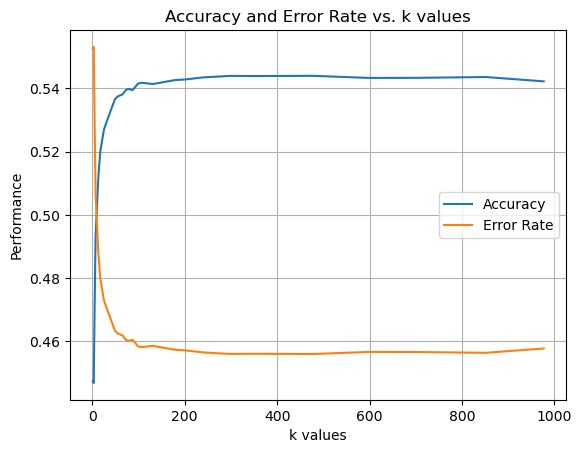

In [16]:
plt.plot(potential_k, accuracy_values, label='Accuracy')
plt.plot(potential_k, error_rate_values, label='Error Rate')
plt.xlabel('k values')
plt.ylabel('Performance')
plt.title('Accuracy and Error Rate vs. k values')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
knn = KNeighborsClassifier(n_neighbors=best_k)

# Train the kNN model on the entire training data
knn.fit(dia_X_train, dia_y_train)

# Predict the class labels for the test data
y_pred_test = knn.predict(dia_X_test)

# Calculate the accuracy of the model on the test data
accuracy_test = accuracy_score(dia_y_test, y_pred_test)

# Print the accuracy on the test data
print("Accuracy on test data:", accuracy_test)

Accuracy on test data: 0.5424101878783114


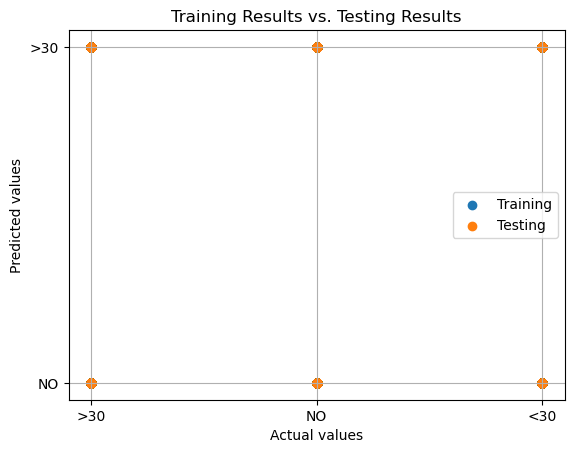

(25442,)
(25442,)
Accuracy: 0.5424101878783114


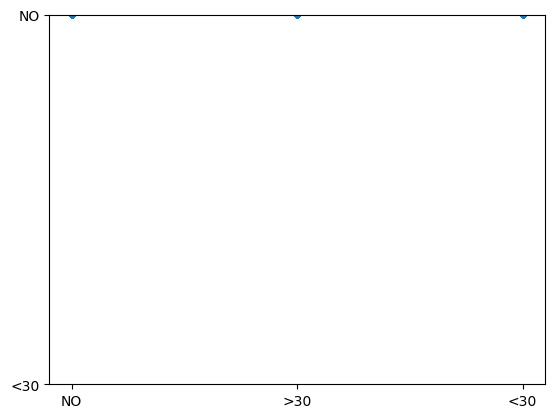

In [34]:
knn = KNeighborsClassifier(n_neighbors=best_k)

# Train the kNN model on the entire training data
knn.fit(dia_X_train, dia_y_train)

# Predict the class labels for the training and test data
y_pred_train = knn.predict(dia_X_train)
y_pred_test = knn.predict(dia_X_test)

# Create a scatter plot of the training vs. testing results
plt.scatter(dia_y_train, y_pred_train, label='Training')
plt.scatter(dia_y_test, y_pred_test, label='Testing')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Training Results vs. Testing Results')
plt.legend()
plt.grid(True)
plt.show()
print(dia_y_test.shape)
print(y_pred_test.shape)
plt.ylim(min(dia_y_test), max(dia_y_test))
plt.scatter(dia_y_test, y_pred_test, label='Testing', s=10)
accuracy = accuracy_score(dia_y_test, y_pred_test)
print("Accuracy:", accuracy)

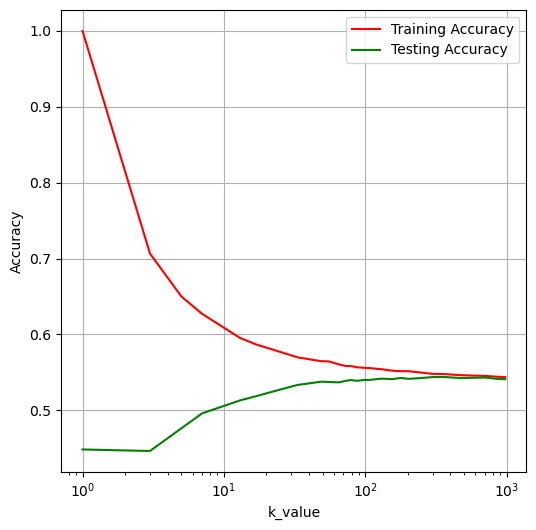

In [33]:
figure, axes = plt.subplots(1, figsize=(6, 6))

train_accuracy = []
test_accuracy = []
encoded_dia_y_test = le.fit_transform(dia_y_test)

for k in potential_k:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(dia_X_train, encoded_dia_y_train)
    diabetes_train = knn.predict(dia_X_train)
    diabetes_test = knn.predict(dia_X_test)

    train_accuracy.append(accuracy_score(encoded_dia_y_train, diabetes_train))
    test_accuracy.append(accuracy_score(encoded_dia_y_test, diabetes_test))

plt.semilogx(potential_k, train_accuracy, label='Training Accuracy', color='red')
plt.semilogx(potential_k, test_accuracy, label='Testing Accuracy', color='green')
plt.xlabel('k_value')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()